### 解析door,window,wall, 输出为YOLO Object Detect格式

In [5]:
import os
from xml.dom import minidom
from PIL import Image
from pathlib import Path
import shutil

def parse_svg(svg_path, image_path):
    """
    从 SVG 文件解析门（包含开合范围）、窗、墙，转换为矩形边界框。
    Args:
        svg_path (str): SVG 文件路径。
        image_path (str): 对应图像文件路径。
    Returns:
        annotations (list): 包含门、窗、墙的边界框信息列表。
        image_height (int): 图像高度。
        image_width (int): 图像宽度。
    """
    # 使用 PIL 只读取图像元数据获取宽高
    try:
        with Image.open(image_path) as img:
            image_width, image_height = img.size
    except Exception as e:
        raise ValueError(f"无法解析图像元数据: {image_path}, 错误: {e}")

    svg = minidom.parse(svg_path)
    annotations = []

    for e in svg.getElementsByTagName('g'):
        if e.getAttribute("id") == "Door":
            min_x, min_y, max_x, max_y = float('inf'), float('inf'), float('-inf'), float('-inf')
            # 解析门的边界框
            polygons = e.getElementsByTagName('polygon')
            if polygons:
                points_str = polygons[0].getAttribute("points")
                points = [list(map(float, p.split(','))) for p in points_str.split()]
                X = [p[0] for p in points]
                Y = [p[1] for p in points]
                min_x = min(min_x, min(X))
                min_y = min(min_y, min(Y))
                max_x = max(max_x, max(X))
                max_y = max(max_y, max(Y))

            # 解析面板的开合范围
            panels = e.getElementsByTagName('path')
            for panel in panels:
                d = panel.getAttribute("d")
                if "q" in d:
                    parts = d.split()
                    start_x = float(parts[0].split('M')[1].split(',')[0]) if 'M' in parts[0] else float(parts[1].split(',')[0])
                    start_y = float(parts[0].split('M')[1].split(',')[1]) if 'M' in parts[0] else float(parts[1].split(',')[1])
                    q_dx = float(parts[2].split(',')[0])
                    q_dy = float(parts[2].split(',')[1])
                    control_x = start_x + q_dx
                    control_y = start_y + q_dy
                    end_x = start_x if 'l' in parts[3] else float(parts[5].split(',')[0])
                    end_y = start_y + q_dy if 'l' in parts[3] else float(parts[5].split(',')[1])

                    all_x = [start_x, control_x, end_x]
                    all_y = [start_y, control_y, end_y]
                    min_x = min(min_x, min(all_x))
                    min_y = min(min_y, min(all_y))
                    max_x = max(max_x, max(all_x))
                    max_y = max(max_y, max(all_y))

            if min_x != float('inf'):
                x_center = (min_x + max_x) / 2 / image_width
                y_center = (min_y + max_y) / 2 / image_height
                width = (max_x - min_x) / image_width
                height = (max_y - min_y) / image_height
                annotations.append({"class_id": 0, "x_center": x_center, "y_center": y_center, "width": width, "height": height})
        elif e.getAttribute("id") == "Window":
            polygons = e.getElementsByTagName('polygon')
            if polygons:
                points_str = polygons[0].getAttribute("points")
                points = [list(map(float, p.split(','))) for p in points_str.split()]
                X = [p[0] for p in points]
                Y = [p[1] for p in points]
                min_x, max_x = min(X), max(X)
                min_y, max_y = min(Y), max(Y)
                x_center = (min_x + max_x) / 2 / image_width
                y_center = (min_y + max_y) / 2 / image_height
                width = (max_x - min_x) / image_width
                height = (max_y - min_y) / image_height
                annotations.append({"class_id": 1, "x_center": x_center, "y_center": y_center, "width": width, "height": height})
        elif e.getAttribute("id") == "Wall":
            polygons = e.getElementsByTagName('polygon')
            if polygons:
                points_str = polygons[0].getAttribute("points")
                points = [list(map(float, p.split(','))) for p in points_str.split()]
                if len(points) > 4:
                    print("Wall is not rectangle, points:", points)
                X = [p[0] for p in points]
                Y = [p[1] for p in points]
                min_x, max_x = min(X), max(X)
                min_y, max_y = min(Y), max(Y)
                x_center = (min_x + max_x) / 2 / image_width
                y_center = (min_y + max_y) / 2 / image_height
                width = (max_x - min_x) / image_width
                height = (max_y - min_y) / image_height
                annotations.append({"class_id": 2, "x_center": x_center, "y_center": y_center, "width": width, "height": height})

    return annotations, image_height, image_width

def convert_to_yolo_format(annotations, yolo_file_path):
    """
    将解析的边界框转换为 YOLOv11 object-detect 格式。
    """
    with open(yolo_file_path, 'w') as f:
        for ann in annotations:
            line = f"{ann['class_id']} {ann['x_center']} {ann['y_center']} {ann['width']} {ann['height']}"
            f.write(line + '\n')

def new_filename(path: Path) -> str:
    """
    根据路径生成新文件名：
    规则：Path 的倒数两级目录名 + 原文件名

    :param path: 文件的 Path 对象
    :return: 新文件名（不含路径）
    """
    # 取倒数两级目录名
    parent_names = path.parents[1].name + "_" + path.parents[0].name
    # 原文件名
    original_name = path.name
    # 拼接
    return f"{parent_names}_{original_name}"


def parse_one_small_dir(dir_path, yolo_base_path):
    """
    处理一个小文件夹，文件夹中有文件
    .  
        -- F1_scaled.png
        -- model.svg
    labelme格式的json文件存在当前目录

    :param dir_path:小文件夹
    :yolo_base_path:YOLO数据集下的train or valid or test目录
    """
    svg_path = os.path.join(dir_path, 'model.svg')
    image_path = os.path.join(dir_path, 'F1_scaled.png')
 
    annotations, image_height, image_width = parse_svg(svg_path, image_path)

    new_image_name = new_filename(Path(image_path))
    new_annotation_name = str(Path(new_image_name).with_suffix('.txt'))

    convert_to_yolo_format(annotations, os.path.join(yolo_base_path, 'labels', new_annotation_name))
    shutil.copy(image_path, os.path.join(yolo_base_path, 'images', new_image_name))

def process(base_path, index_file, yolo):
 
    success_count = 0
    fail_count = 0
    with open(index_file, 'r', encoding='utf-8') as f:
        for line in f:
            relative_path = line.strip().lstrip('/\\')  # 去掉首尾空格，并去掉开头的 / 或 \
            full_path = os.path.join(base_path, relative_path)
            try:
                parse_one_small_dir(full_path, yolo)
                success_count += 1
                if success_count % 50 == 0:
                    print(f"成功处理数量：{success_count}")
            except Exception as e:
                print(f"发生错误，文件夹：{relative_path}")
                print(f"错误信息：{e}")
                fail_count += 1
     
    print(f"运行结束，成功：{success_count}, 失败：{fail_count}")


In [3]:
# 示例使用
svg_path = '/Users/wm/workspace/dataset/test/30/model.svg'
image_path = '/Users/wm/workspace/dataset/test/30/F1_scaled.png'
annotations, image_height, image_width = parse_svg(svg_path, image_path)

if annotations:
    yolo_file_path = 'image1.txt'
    convert_to_yolo_format(annotations, yolo_file_path)
    print(f"Generated YOLOv11 annotation: {yolo_file_path}")
else:
    print("No door or window found in SVG.")

Generated YOLOv11 annotation: image1.txt


In [ ]:
from pathlib import Path

# yolo_base_path: 希望输出的YOLO格式数据集的位置
# yolo_base_path = Path('/kaggle/working/CubiCasa5k_yolo')
yolo_base_path = Path('/kaggle/working/CubiCasa5k_yolo')
yolo_base_path.mkdir(parents=True, exist_ok=True)
(yolo_base_path / 'train').mkdir(parents=True, exist_ok=True)
(yolo_base_path / 'train' / 'images').mkdir(parents=True, exist_ok=True)
(yolo_base_path / 'train' / 'labels').mkdir(parents=True, exist_ok=True)
(yolo_base_path / 'test').mkdir(parents=True, exist_ok=True)
(yolo_base_path / 'test' / 'images').mkdir(parents=True, exist_ok=True)
(yolo_base_path / 'test' / 'labels').mkdir(parents=True, exist_ok=True)
(yolo_base_path / 'valid').mkdir(parents=True, exist_ok=True)
(yolo_base_path / 'valid' / 'images').mkdir(parents=True, exist_ok=True)
(yolo_base_path / 'valid' / 'labels').mkdir(parents=True, exist_ok=True)

base_path = '/kaggle/input/cubicasa5k/cubicasa5k/cubicasa5k'

process(base_path, os.path.join(base_path, 'test.txt'), str(yolo_base_path / 'test'))
process(base_path, os.path.join(base_path, 'val.txt'), str(yolo_base_path / 'valid'))
process(base_path, os.path.join(base_path, 'train.txt'), str(yolo_base_path / 'train'))


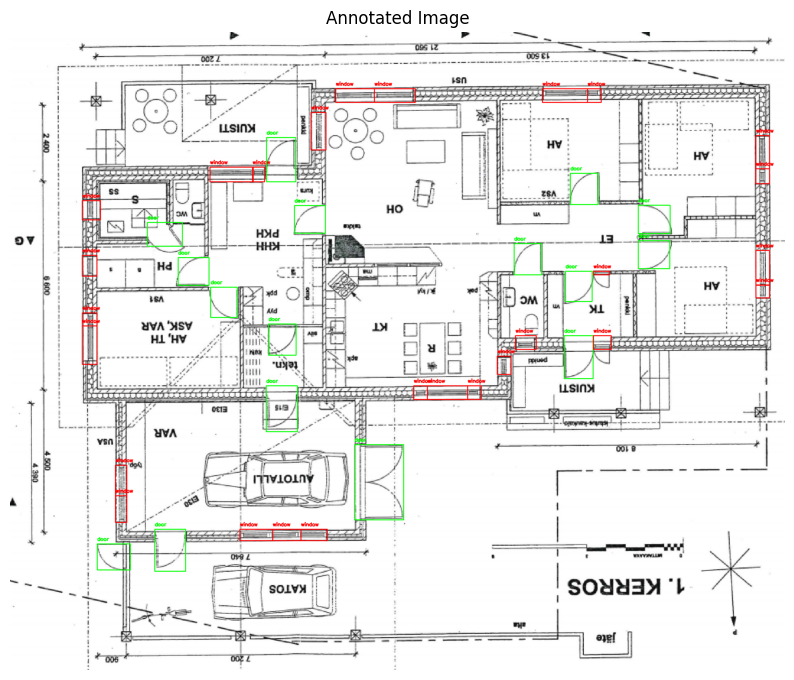

: 

In [ ]:
import cv2
import os
from IPython.display import display
import matplotlib.pyplot as plt

def draw_yolo_annotations(image_path, annotation_path):
    """
    在图片上绘制 YOLOv11 (detect) 格式的标注框，并在 Jupyter Notebook 中显示。
    Args:
        image_path (str): 图片文件路径。
        annotation_path (str): YOLOv11 标注文件路径 (.txt)。
    """
    # 读取图片
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"无法读取图片文件: {image_path}")

    # 转换为 RGB（因为 cv2 读取为 BGR，matplotlib 需要 RGB）
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 获取图片尺寸
    image_height, image_width = img.shape[:2]

    # 读取 YOLO 标注文件
    if not os.path.exists(annotation_path):
        raise ValueError(f"无法找到标注文件: {annotation_path}")

    with open(annotation_path, 'r') as f:
        for line in f:
            # 解析每行：class_id x_center y_center width height
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            class_id = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])

            # 转换为像素坐标
            x1 = int((x_center - width / 2) * image_width)
            y1 = int((y_center - height / 2) * image_height)
            x2 = int((x_center + width / 2) * image_width)
            y2 = int((y_center + height / 2) * image_height)

            # 确保坐标在图片范围内
            x1 = max(0, min(x1, image_width))
            y1 = max(0, min(y1, image_height))
            x2 = max(0, min(x2, image_width))
            y2 = max(0, min(y2, image_height))

            # 设置颜色和标签
            if class_id == 0:  # door
                color = (0, 255, 0)  # 绿色
                label = "door"
            elif class_id == 1:  # window
                color = (255, 0, 0)  # 蓝色
                label = "window"
            else:
                continue  # 忽略未知类

            # 绘制矩形框
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
            # 添加标签
            cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # 在 Jupyter Notebook 中显示
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')  # 隐藏坐标轴
    plt.title('Annotated Image')
    display(plt.gcf())
    plt.close()  # 关闭图形，防止内存泄漏

# 示例使用
image_path = '/Users/wm/workspace/dataset/CubiCasa5k_yolo/train/images/high_quality_architectural_190_F1_scaled.png'
annotation_path = '/Users/wm/workspace/dataset/CubiCasa5k_yolo/train/labels/high_quality_architectural_190_F1_scaled.txt'
draw_yolo_annotations(image_path, annotation_path)